In [1]:
#from generator import UNETGenerator
from keras.layers import Activation, Input, Dropout, merge,concatenate
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers import Conv2D,Conv2DTranspose,Flatten,Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU,ReLU
from keras.models import Model
import cv2
from collections import deque
from keras.optimizers import Adam
import numpy as np

Using TensorFlow backend.


In [2]:
import gym
import random
import keras

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [23]:
# Hyper Parameters for DQN
GAMMA = 0.9 # discount factor for target Q
INITIAL_EPSILON = 0.5 # starting value of epsilon
FINAL_EPSILON = 0.01 # final value of epsilon
REPLAY_SIZE = 5000 # experience replay buffer size
BATCH_SIZE = 32 # size of minibatch
IMG_SIZE = 80

In [5]:
def preprocess(img):
    img_temp = img.mean(axis = 2)
#    img_temp = cv2.resize(img_temp,(IMG_SIZE,IMG_SIZE))
    x = -1
    y = -1
    flag = 0
    if len(np.where((img_temp[100:189,8:152])!= 0)[0]) != 0:
        x = np.where((img_temp[100:189,8:152])!= 0)[0][0]
        y = np.where((img_temp[100:189,8:152])!= 0)[1][0]
    if len(np.where((img_temp[193:,8:152])!= 0)[0]) != 0:
        x = np.where((img_temp[193:,8:152])!= 0)[0][0] + 93
        y = np.where((img_temp[193:,8:152])!= 0)[1][0]
        flag = 1
#         x = -2
#         y = -2
    p = int(np.where(img_temp[191:193,8:152])[1].mean() - 7.5)
    #return img_temp
    return (x,y,p,flag)

In [6]:
# ---------------------------------------------------------
# Hyper Parameters
ENV_NAME = 'Breakout-v0'
EPISODE = 15000 # Episode limitation
STEP = 500 # Step limitation in an episode
TEST = 10 # The number of experiment test every 100 episode

In [7]:
class DQN():
  # DQN Agent
  def __init__(self, env):
    # init experience replay
    self.replay_buffer = deque()
    # init some parameters
    self.time_step = 0
    self.epsilon = INITIAL_EPSILON
    self.learning_rate = 0.0001
    #self.state_dim = env.observation_space.shape[0]
    self.state_dim = (IMG_SIZE,IMG_SIZE)
    self.action_dim = env.action_space.n - 1 

    self.create_Q_network()
    #self.create_training_method()

    # Init session
#     self.session = tf.InteractiveSession()
#     self.session.run(tf.initialize_all_variables())

# 更改state为：
#    - 只使用屏幕的下半部分。（先不去关心具体撞击分数，只要接住）
#    - 连续两帧球的轨迹，只有球在下半部分再行动。 
#    - (x1,y1,x2,y2,p) p是平台的位置
  
  def create_Q_network(self):
    # network weights
    input_layer = Input(shape=(5,), name="unet_input")
    fc1 = Dense(128)(input_layer)
    fc1 = LeakyReLU(alpha=0.1)(fc1)
    fc2 = Dense(64)(fc1)
    fc2 = LeakyReLU(alpha=0.1)(fc2)
    fc3 = Dense(16)(fc2)
    fc3 = LeakyReLU(alpha=0.1)(fc3)
    #get Q_value
    q_value= Dense(self.action_dim)(fc3)
    self.model = Model(input=[input_layer], output=[q_value], name='Q_net')
    self.model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))

    # target net
    self.target_model = keras.models.clone_model(self.model)
    self.target_model.set_weights(self.model.get_weights())

  def update_target(self):
    self.target_model.set_weights(self.model.get_weights())
    
  def perceive(self,state,action,reward,next_state,done):
    next_q_value = self.target_model.predict(np.expand_dims(next_state,0))
    self.replay_buffer.append((state,action,reward,next_q_value[0],done))
    if len(self.replay_buffer) > REPLAY_SIZE:
      self.replay_buffer.popleft()

    if len(self.replay_buffer) > BATCH_SIZE:
      return self.train_Q_network()

  def train_Q_network(self):
    self.time_step += 1
    # Step 1: obtain random minibatch from replay memory
    minibatch = random.sample(self.replay_buffer,BATCH_SIZE)
    state_batch = np.array([data[0] for data in minibatch])
    action_batch = np.array([data[1] for data in minibatch])
    reward_batch = np.array([data[2] for data in minibatch])
    next_q_batch = np.array([data[3] for data in minibatch])

    # Step 2: calculate y
    y_batch = []
    for i in range(0,BATCH_SIZE):
      done = minibatch[i][4]
      if done:
        y_batch.append(reward_batch[i])
      else :
        y_batch.append(reward_batch[i] + GAMMA * np.max(next_q_batch[i]))

    # 获得训练的target
    
    label_f = self.model.predict(state_batch)
    for i in range(0,BATCH_SIZE):
        label_f[i][action_batch[i]-1] = y_batch[i]
    
    return self.model.fit(state_batch,label_f)
    
  def egreedy_action(self,state):
    if state[0] < 0:
        return 1;
    Q_value = self.model.predict(np.expand_dims(state,0))[0]
    if random.random() <= self.epsilon:
      return random.randint(0,self.action_dim - 1) + 1
    else:
      return np.argmax(Q_value) + 1

  def action(self,state):
    if state[0] < 0:
        return 1;
    return np.argmax(self.model.predict(np.expand_dims(state,0))[0]) + 1

In [24]:
from IPython import display
def main(env):
  # initialize OpenAI Gym env and dqn agent

#   agent.model.summary()
#   return 
  for episode in range(EPISODE):
    # initialize task
    log_file = open("m_log2.log","a")
    state = env.reset()
    (x1,y1,p1,flag) = preprocess(state)
    # Train
    state_shadow = np.array([x1,y1,x1,y1,p1])
    total_loss = 0 
    total_reward = 0
    for step in range(STEP):
        print("episode:%d step:%d" % (episode,step))
        action = agent.egreedy_action(state_shadow)    
        next_state,reward,done,_ = env.step(action)
        (x2,y2,p2,flag) = preprocess(next_state)
        next_state_shadow = np.array([x1,y1,x2,y2,p2])
        # Define reward for agent
        #reward_agent = -1 if done else 0.1
        #加大落下的惩罚
        if flag == 1:
            reward = -10
            done = True
        else:
            reward = 0.1
        agent.perceive(state_shadow,action,reward,next_state_shadow,done)
#         if cur_loss is not None:
#             total_loss += cur_loss
        total_reward += reward
        state_shadow = next_state_shadow
        x1,y1,p1 = x2,y2,p2
        if done:
            break
    agent.epsilon -= (INITIAL_EPSILON - FINAL_EPSILON)/EPISODE
    print("total_loss:{} total_reward:{}".format(total_loss,total_reward))
    # Test every 1000 episodes
    
    if episode % 10 == 0:
        agent.update_target()
        
    if episode % 100 == 0:
        display.clear_output(wait=True)
        agent.model.save_weights("models/model2_{}.h5".format(episode))
        total_reward = 0
        for i in range(TEST):
            state = env.reset()
            (x1,y1,p1,flag) = preprocess(state)
            state_shadow = np.array([x1,y1,x1,y1,p1])
            for j in range(STEP):
                #env.render(mode='rgb_array')
                action = agent.action(state_shadow) # direct action for test
                next_state,reward,done,_ = env.step(action)
                #state = preprocess(state)
                (x2,y2,p2,flag) = preprocess(next_state)
                if flag == 1:
                    reward = -10
                    done = True
                else:
                    reward = 0.1
                next_state_shadow = np.array([x1,y1,x2,y2,p2])
                total_reward += reward
                state_shadow = next_state_shadow
                x1,y1,p1 = x2,y2,p2
                if done:
                    break
        ave_reward = total_reward/TEST
        log_file.write('episode: {} Evaluation Average Reward: {}\r\n'.format(episode,ave_reward))
        if ave_reward >= 280:
            break
    log_file.close()

In [12]:
env = gym.make(ENV_NAME)
agent = DQN(env)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="Q_net", inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [25]:
main(env)

episode:1901 step:0
Epoch 1/1
32/32 [==============================] - 0s 83us/step - loss: 0.0461
episode:1901 step:1
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.0684
episode:1901 step:2
Epoch 1/1
32/32 [==============================] - 0s 66us/step - loss: 0.0275
episode:1901 step:3
Epoch 1/1
32/32 [==============================] - 0s 69us/step - loss: 0.0558
episode:1901 step:4
Epoch 1/1
32/32 [==============================] - 0s 65us/step - loss: 0.0689
episode:1901 step:5
Epoch 1/1
32/32 [==============================] - 0s 67us/step - loss: 0.3975
episode:1901 step:6
Epoch 1/1
32/32 [==============================] - 0s 64us/step - loss: 0.1113
episode:1901 step:7
Epoch 1/1
32/32 [==============================] - 0s 56us/step - loss: 0.0418
episode:1901 step:8
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.0142
episode:1901 step:9
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.1516
episode:19

episode:1902 step:57
Epoch 1/1
32/32 [==============================] - 0s 87us/step - loss: 0.1482
episode:1902 step:58
Epoch 1/1
32/32 [==============================] - 0s 85us/step - loss: 0.0484
episode:1902 step:59
Epoch 1/1
32/32 [==============================] - 0s 93us/step - loss: 0.0320
episode:1902 step:60
Epoch 1/1
32/32 [==============================] - 0s 88us/step - loss: 0.1700
episode:1902 step:61
Epoch 1/1
32/32 [==============================] - 0s 84us/step - loss: 0.0763
episode:1902 step:62
Epoch 1/1
32/32 [==============================] - 0s 83us/step - loss: 0.0261
episode:1902 step:63
Epoch 1/1
32/32 [==============================] - 0s 80us/step - loss: 0.0173
episode:1902 step:64
Epoch 1/1
32/32 [==============================] - 0s 83us/step - loss: 0.0235
episode:1902 step:65
Epoch 1/1
32/32 [==============================] - 0s 77us/step - loss: 0.0159
total_loss:0 total_reward:-3.500000000000007
episode:1903 step:0
Epoch 1/1
32/32 [==================

32/32 [==============================] - 0s 122us/step - loss: 0.0725
episode:1904 step:6
Epoch 1/1
32/32 [==============================] - 0s 74us/step - loss: 0.4663
episode:1904 step:7
Epoch 1/1
32/32 [==============================] - 0s 77us/step - loss: 0.5393
episode:1904 step:8
Epoch 1/1
32/32 [==============================] - 0s 90us/step - loss: 0.0156
episode:1904 step:9
Epoch 1/1
32/32 [==============================] - 0s 76us/step - loss: 0.0127
episode:1904 step:10
Epoch 1/1
32/32 [==============================] - 0s 70us/step - loss: 0.0403
episode:1904 step:11
Epoch 1/1
32/32 [==============================] - 0s 75us/step - loss: 0.0157
episode:1904 step:12
Epoch 1/1
32/32 [==============================] - 0s 78us/step - loss: 0.0356
episode:1904 step:13
Epoch 1/1
32/32 [==============================] - 0s 77us/step - loss: 0.3254
episode:1904 step:14
Epoch 1/1
32/32 [==============================] - 0s 74us/step - loss: 0.2349
episode:1904 step:15
Epoch 1/1
32/

32/32 [==============================] - 0s 68us/step - loss: 0.2433
episode:1904 step:88
Epoch 1/1
32/32 [==============================] - 0s 73us/step - loss: 0.0199
episode:1904 step:89
Epoch 1/1
32/32 [==============================] - 0s 74us/step - loss: 0.0071
episode:1904 step:90
Epoch 1/1
32/32 [==============================] - 0s 131us/step - loss: 0.0536
episode:1904 step:91
Epoch 1/1
32/32 [==============================] - 0s 73us/step - loss: 0.1165
episode:1904 step:92
Epoch 1/1
32/32 [==============================] - 0s 73us/step - loss: 0.0310
episode:1904 step:93
Epoch 1/1
32/32 [==============================] - 0s 71us/step - loss: 0.0320
episode:1904 step:94
Epoch 1/1
32/32 [==============================] - 0s 72us/step - loss: 0.1782
episode:1904 step:95
Epoch 1/1
32/32 [==============================] - 0s 77us/step - loss: 0.0553
episode:1904 step:96
Epoch 1/1
32/32 [==============================] - 0s 77us/step - loss: 0.0290
episode:1904 step:97
Epoch 1/1

episode:1904 step:169
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.5807
episode:1904 step:170
Epoch 1/1
32/32 [==============================] - 0s 64us/step - loss: 0.0820
episode:1904 step:171
Epoch 1/1
32/32 [==============================] - 0s 56us/step - loss: 0.0791
episode:1904 step:172
Epoch 1/1
32/32 [==============================] - 0s 55us/step - loss: 0.0744
episode:1904 step:173
Epoch 1/1
32/32 [==============================] - 0s 66us/step - loss: 0.0287
episode:1904 step:174
Epoch 1/1
32/32 [==============================] - 0s 62us/step - loss: 0.0442
episode:1904 step:175
Epoch 1/1
32/32 [==============================] - 0s 64us/step - loss: 0.0315
episode:1904 step:176
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.3519
episode:1904 step:177
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.0239
episode:1904 step:178
Epoch 1/1
32/32 [==============================] - 0s 58us/step - los

total_loss:0 total_reward:-3.7000000000000064
episode:1906 step:0
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 1.3254
episode:1906 step:1
Epoch 1/1
32/32 [==============================] - 0s 64us/step - loss: 0.0530
episode:1906 step:2
Epoch 1/1
32/32 [==============================] - 0s 65us/step - loss: 0.0335
episode:1906 step:3
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.0589
episode:1906 step:4
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.0524
episode:1906 step:5
Epoch 1/1
32/32 [==============================] - 0s 62us/step - loss: 0.0565
episode:1906 step:6
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.0813
episode:1906 step:7
Epoch 1/1
32/32 [==============================] - 0s 65us/step - loss: 0.0456
episode:1906 step:8
Epoch 1/1
32/32 [==============================] - 0s 64us/step - loss: 0.0150
episode:1906 step:9
Epoch 1/1
32/32 [==========================

32/32 [==============================] - 0s 60us/step - loss: 0.0468
episode:1907 step:16
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.0302
episode:1907 step:17
Epoch 1/1
32/32 [==============================] - 0s 64us/step - loss: 0.1002
episode:1907 step:18
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.0819
episode:1907 step:19
Epoch 1/1
32/32 [==============================] - 0s 66us/step - loss: 0.0524
episode:1907 step:20
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.0558
episode:1907 step:21
Epoch 1/1
32/32 [==============================] - 0s 54us/step - loss: 0.1006
episode:1907 step:22
Epoch 1/1
32/32 [==============================] - 0s 62us/step - loss: 0.0219
total_loss:0 total_reward:-7.799999999999999
episode:1908 step:0
Epoch 1/1
32/32 [==============================] - 0s 54us/step - loss: 0.0874
episode:1908 step:1
Epoch 1/1
32/32 [==============================] - 0s 60us/step - l

episode:1908 step:74
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.0489
episode:1908 step:75
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.1933
episode:1908 step:76
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.0314
episode:1908 step:77
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.1285
episode:1908 step:78
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.0996
episode:1908 step:79
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.1351
episode:1908 step:80
Epoch 1/1
32/32 [==============================] - 0s 69us/step - loss: 0.0234
episode:1908 step:81
Epoch 1/1
32/32 [==============================] - 0s 64us/step - loss: 0.0439
episode:1908 step:82
Epoch 1/1
32/32 [==============================] - 0s 54us/step - loss: 0.2096
episode:1908 step:83
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.2007


episode:1908 step:156
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.0184
episode:1908 step:157
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.2762
episode:1908 step:158
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.0213
episode:1908 step:159
Epoch 1/1
32/32 [==============================] - 0s 55us/step - loss: 0.0297
episode:1908 step:160
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.0220
episode:1908 step:161
Epoch 1/1
32/32 [==============================] - 0s 64us/step - loss: 0.6713
episode:1908 step:162
Epoch 1/1
32/32 [==============================] - 0s 69us/step - loss: 0.0547
episode:1908 step:163
Epoch 1/1
32/32 [==============================] - 0s 67us/step - loss: 0.1064
episode:1908 step:164
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.0481
episode:1908 step:165
Epoch 1/1
32/32 [==============================] - 0s 57us/step - los

episode:1909 step:23
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.4723
episode:1909 step:24
Epoch 1/1
32/32 [==============================] - 0s 71us/step - loss: 0.0503
episode:1909 step:25
Epoch 1/1
32/32 [==============================] - 0s 65us/step - loss: 0.0599
episode:1909 step:26
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.0288
episode:1909 step:27
Epoch 1/1
32/32 [==============================] - 0s 65us/step - loss: 0.0865
episode:1909 step:28
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.0096
episode:1909 step:29
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.4448
episode:1909 step:30
Epoch 1/1
32/32 [==============================] - 0s 58us/step - loss: 0.0537
episode:1909 step:31
Epoch 1/1
32/32 [==============================] - 0s 64us/step - loss: 0.0225
episode:1909 step:32
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.2367


episode:1909 step:105
Epoch 1/1
32/32 [==============================] - 0s 68us/step - loss: 0.0495
episode:1909 step:106
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.0088
episode:1909 step:107
Epoch 1/1
32/32 [==============================] - 0s 71us/step - loss: 0.0824
episode:1909 step:108
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.0680
episode:1909 step:109
Epoch 1/1
32/32 [==============================] - 0s 67us/step - loss: 0.0629
episode:1909 step:110
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.2325
episode:1909 step:111
Epoch 1/1
32/32 [==============================] - 0s 75us/step - loss: 0.5362
episode:1909 step:112
Epoch 1/1
32/32 [==============================] - 0s 63us/step - loss: 0.0230
episode:1909 step:113
Epoch 1/1
32/32 [==============================] - 0s 62us/step - loss: 0.0151
episode:1909 step:114
Epoch 1/1
32/32 [==============================] - 0s 67us/step - los

Epoch 1/1
32/32 [==============================] - 0s 54us/step - loss: 0.2096
episode:1909 step:187
Epoch 1/1
32/32 [==============================] - 0s 72us/step - loss: 0.0265
episode:1909 step:188
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.0656
episode:1909 step:189
Epoch 1/1
32/32 [==============================] - 0s 55us/step - loss: 0.1262
episode:1909 step:190
Epoch 1/1
32/32 [==============================] - 0s 64us/step - loss: 0.1048
episode:1909 step:191
Epoch 1/1
32/32 [==============================] - 0s 66us/step - loss: 0.8469
episode:1909 step:192
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.0940
episode:1909 step:193
Epoch 1/1
32/32 [==============================] - 0s 58us/step - loss: 0.4948
episode:1909 step:194
Epoch 1/1
32/32 [==============================] - 0s 63us/step - loss: 0.2055
episode:1909 step:195
Epoch 1/1
32/32 [==============================] - 0s 63us/step - loss: 0.1302
episode:1909

Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.0489
episode:1910 step:16
Epoch 1/1
32/32 [==============================] - 0s 55us/step - loss: 0.0220
episode:1910 step:17
Epoch 1/1
32/32 [==============================] - 0s 63us/step - loss: 0.0303
episode:1910 step:18
Epoch 1/1
32/32 [==============================] - 0s 65us/step - loss: 0.0503
episode:1910 step:19
Epoch 1/1
32/32 [==============================] - 0s 67us/step - loss: 0.2337
episode:1910 step:20
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.0434
episode:1910 step:21
Epoch 1/1
32/32 [==============================] - 0s 67us/step - loss: 0.0286
episode:1910 step:22
Epoch 1/1
32/32 [==============================] - 0s 56us/step - loss: 0.0393
episode:1910 step:23
Epoch 1/1
32/32 [==============================] - 0s 55us/step - loss: 0.0856
episode:1910 step:24
Epoch 1/1
32/32 [==============================] - 0s 64us/step - loss: 0.0135
episode:1910 step:25


episode:1911 step:34
Epoch 1/1
32/32 [==============================] - 0s 58us/step - loss: 0.0301
episode:1911 step:35
Epoch 1/1
32/32 [==============================] - 0s 62us/step - loss: 0.0167
episode:1911 step:36
Epoch 1/1
32/32 [==============================] - 0s 65us/step - loss: 0.0642
episode:1911 step:37
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.0600
episode:1911 step:38
Epoch 1/1
32/32 [==============================] - 0s 56us/step - loss: 0.0288
episode:1911 step:39
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.4321
episode:1911 step:40
Epoch 1/1
32/32 [==============================] - 0s 68us/step - loss: 0.0212
episode:1911 step:41
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.5195
episode:1911 step:42
Epoch 1/1
32/32 [==============================] - 0s 63us/step - loss: 0.0434
episode:1911 step:43
Epoch 1/1
32/32 [==============================] - 0s 53us/step - loss: 0.1659


episode:1912 step:56
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.0221
episode:1912 step:57
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.0314
episode:1912 step:58
Epoch 1/1
32/32 [==============================] - 0s 72us/step - loss: 0.0394
episode:1912 step:59
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.1006
episode:1912 step:60
Epoch 1/1
32/32 [==============================] - 0s 58us/step - loss: 0.0510
episode:1912 step:61
Epoch 1/1
32/32 [==============================] - 0s 63us/step - loss: 0.0403
episode:1912 step:62
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.0459
episode:1912 step:63
Epoch 1/1
32/32 [==============================] - 0s 71us/step - loss: 0.0351
episode:1912 step:64
Epoch 1/1
32/32 [==============================] - 0s 62us/step - loss: 0.0101
episode:1912 step:65
Epoch 1/1
32/32 [==============================] - 0s 67us/step - loss: 0.0286


episode:1913 step:71
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.0281
episode:1913 step:72
Epoch 1/1
32/32 [==============================] - 0s 54us/step - loss: 0.0131
episode:1913 step:73
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.4696
episode:1913 step:74
Epoch 1/1
32/32 [==============================] - 0s 53us/step - loss: 0.0181
episode:1913 step:75
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.0089
episode:1913 step:76
Epoch 1/1
32/32 [==============================] - 0s 62us/step - loss: 0.0178
episode:1913 step:77
Epoch 1/1
32/32 [==============================] - 0s 56us/step - loss: 0.0431
episode:1913 step:78
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.0364
episode:1913 step:79
Epoch 1/1
32/32 [==============================] - 0s 64us/step - loss: 0.1696
episode:1913 step:80
Epoch 1/1
32/32 [==============================] - 0s 65us/step - loss: 0.1655


episode:1914 step:43
Epoch 1/1
32/32 [==============================] - 0s 63us/step - loss: 0.0574
episode:1914 step:44
Epoch 1/1
32/32 [==============================] - 0s 62us/step - loss: 0.0985
episode:1914 step:45
Epoch 1/1
32/32 [==============================] - 0s 63us/step - loss: 0.0442
episode:1914 step:46
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.0513
episode:1914 step:47
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.2228
episode:1914 step:48
Epoch 1/1
32/32 [==============================] - 0s 58us/step - loss: 0.1025
episode:1914 step:49
Epoch 1/1
32/32 [==============================] - 0s 63us/step - loss: 0.0181
episode:1914 step:50
Epoch 1/1
32/32 [==============================] - 0s 58us/step - loss: 0.0475
episode:1914 step:51
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.1232
episode:1914 step:52
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.0798


episode:1915 step:59
Epoch 1/1
32/32 [==============================] - 0s 58us/step - loss: 0.0376
episode:1915 step:60
Epoch 1/1
32/32 [==============================] - 0s 55us/step - loss: 0.0690
episode:1915 step:61
Epoch 1/1
32/32 [==============================] - 0s 62us/step - loss: 0.0239
episode:1915 step:62
Epoch 1/1
32/32 [==============================] - 0s 56us/step - loss: 0.0213
episode:1915 step:63
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.0161
total_loss:0 total_reward:-3.7000000000000064
episode:1916 step:0
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.2177
episode:1916 step:1
Epoch 1/1
32/32 [==============================] - 0s 68us/step - loss: 0.0353
episode:1916 step:2
Epoch 1/1
32/32 [==============================] - 0s 68us/step - loss: 0.2538
episode:1916 step:3
Epoch 1/1
32/32 [==============================] - 0s 55us/step - loss: 0.0595
episode:1916 step:4
Epoch 1/1
32/32 [=====================

episode:1916 step:77
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.0998
episode:1916 step:78
Epoch 1/1
32/32 [==============================] - 0s 55us/step - loss: 0.2193
episode:1916 step:79
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.0189
episode:1916 step:80
Epoch 1/1
32/32 [==============================] - 0s 63us/step - loss: 0.0195
episode:1916 step:81
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.0439
episode:1916 step:82
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.0283
episode:1916 step:83
Epoch 1/1
32/32 [==============================] - 0s 58us/step - loss: 0.1557
episode:1916 step:84
Epoch 1/1
32/32 [==============================] - 0s 55us/step - loss: 0.0399
episode:1916 step:85
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.1219
episode:1916 step:86
Epoch 1/1
32/32 [==============================] - 0s 67us/step - loss: 0.0241


32/32 [==============================] - 0s 61us/step - loss: 0.4436
episode:1917 step:25
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 0.2334
episode:1917 step:26
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.0333
episode:1917 step:27
Epoch 1/1
32/32 [==============================] - 0s 58us/step - loss: 0.0143
episode:1917 step:28
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.0266
episode:1917 step:29
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 0.0465
episode:1917 step:30
Epoch 1/1
32/32 [==============================] - 0s 67us/step - loss: 0.0958
episode:1917 step:31
Epoch 1/1
32/32 [==============================] - 0s 70us/step - loss: 0.0353
episode:1917 step:32
Epoch 1/1
32/32 [==============================] - 0s 62us/step - loss: 0.0311
episode:1917 step:33
Epoch 1/1
32/32 [==============================] - 0s 53us/step - loss: 0.0310
episode:1917 step:34
Epoch 1/1


episode:1918 step:39
Epoch 1/1
32/32 [==============================] - 0s 63us/step - loss: 1.3378
episode:1918 step:40
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.0197
episode:1918 step:41
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.2389
episode:1918 step:42
Epoch 1/1
32/32 [==============================] - 0s 62us/step - loss: 0.0237
episode:1918 step:43
Epoch 1/1
32/32 [==============================] - 0s 60us/step - loss: 0.4697
episode:1918 step:44
Epoch 1/1
32/32 [==============================] - 0s 58us/step - loss: 0.0651
episode:1918 step:45
Epoch 1/1
32/32 [==============================] - 0s 63us/step - loss: 0.1003
episode:1918 step:46
Epoch 1/1
32/32 [==============================] - 0s 59us/step - loss: 0.0751
episode:1918 step:47
Epoch 1/1
32/32 [==============================] - 0s 66us/step - loss: 0.5067
episode:1918 step:48
Epoch 1/1
32/32 [==============================] - 0s 69us/step - loss: 0.0135


KeyboardInterrupt: 

In [40]:
agent.model.load_weights("models/model2_1000.h5")

In [46]:
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

total_reward = 0
env = gym.make('Breakout-v0')
state = env.reset()
(x1,y1,p1,flag) = preprocess(state)
state_shadow = np.array([x1,y1,x1,y1,p1])
for j in range(1000):
    env.render(mode='rgb_array')
    action = agent.action(state_shadow) # direct action for test
    #action = env.action_space.sample()
    next_state,reward,done,_ = env.step(action)
    #state = preprocess(state)
    (x2,y2,p2,flag) = preprocess(next_state)
    if flag == 1:
        reward = -1
        #done = True
    else:
        reward = 0.1
    next_state_shadow = np.array([x1,y1,x2,y2,p2])
    total_reward += reward
    state_shadow = next_state_shadow
    x1,y1,p1 = x2,y2,p2
    cv2.putText(next_state, "%d:%d:%d:%d:%d:%d" %(action,total_reward,j,x2,y2,p2), (20, 30), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), 0)
#     plt.imshow(next_state)
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
    if done:
        break
print(total_reward)

SyntaxError: invalid character in identifier (<ipython-input-46-e669f797f058>, line 28)

In [25]:
display.clear_output(wait=True)
#agent.model.save_weights("model_{}.h5".format(episode))
total_reward = 0
for i in range(TEST):
    state = env.reset()
    (x1,y1,p1) = preprocess(state)
    state_shadow = np.array([x1,y1,x1,y1,p1])
    for j in range(STEP):
        env.render(mode='rgb_array')
        action = agent.action(state_shadow) # direct action for test
        next_state,reward,done,_ = env.step(action)
        #state = preprocess(state)
        (x2,y2,p2) = preprocess(next_state)
        if x2 == -2:
            reward = -50
        else:
            reward = 1
        next_state_shadow = np.array([x1,y1,x2,y2,p2])
        print(next_state_shadow,action)
        total_reward += reward
        state_shadow = next_state_shadow
        x1,y1,p1 = x2,y2,p2
        if done:
            break
ave_reward = total_reward/TEST
print('Evaluation Average Reward:',ave_reward)

[-1 -1 24 74 91] 1
[24 74 26 76 91] 1
[ 26  76  30  80 103] 2
[ 30  80  34  84 113] 1
[ 34  84  38  88 113] 1
[ 38  88  41  91 113] 1
[ 41  91  43  93 116] 2
[ 43  93  46  96 129] 2
[ 46  96  48  98 132] 2
[ 48  98  51 101 132] 2
[ 51 101  54 104 132] 2
[ 54 104  57 107 132] 2
[ 57 107  60 110 132] 2
[ 60 110  63 113 132] 2
[ 63 113  65 115 132] 2
[ 65 115  67 117 132] 2
[ 67 117  70 120 132] 2
[ 70 120  73 123 132] 2
[ 73 123  76 126 132] 2
[ 76 126  80 130 132] 2
[ 80 130  83 133 132] 2
[ 83 133  86 136 132] 2
[ 86 136  83 131 132] 2
[ 83 131  79 125 132] 2
[ 79 125  75 119 132] 2
[ 75 119  73 116 132] 2
[ 73 116  71 113 132] 2
[ 71 113  68 109 132] 2
[ 68 109  66 106 132] 2
[ 66 106  63 101 132] 2
[ 63 101  61  98 132] 3
[ 61  98  58  94 132] 3
[ 58  94  56  91 132] 3
[ 56  91  54  88 132] 3
[ 54  88  51  83 128] 3
[ 51  83  47  77 105] 3
[47 77 43 71 83] 3
[43 71 41 68 71] 3
[41 68 38 64 54] 3
[38 64 34 58 31] 3
[34 58 31 53 13] 3
[31 53 27 47  0] 3
[27 47 23 41  0] 3
[23 41 21 38 

[72 23 75 21  0] 3
[75 21 80 18  0] 3
[80 18 86 14  0] 3
[86 14 82 20  0] 3
[82 20 78 26  9] 2
[78 26 75 30 25] 2
[75 30 72 35 42] 2
[72 35 70 38 54] 2
[70 38 67 42 71] 2
[67 42 64 47 88] 2
[ 64  47  62  50 100] 2
[ 62  50  58  56 122] 2
[ 58  56  55  60 132] 2
[ 55  60  52  65 132] 2
[ 52  65  48  71 132] 2
[ 48  71  44  77 132] 2
[ 44  77  40  83 132] 2
[ 40  83  38  86 132] 2
[ 38  86  36  89 132] 2
[ 36  89  34  92 132] 2
[ 34  92  32  95 132] 2
[ 32  95  30  98 132] 2
[ 30  98  26 104 132] 2
[ 26 104  22 110 132] 2
[ 22 110  19 114 132] 2
[ 19 114  15 120 132] 2
[ 15 120  13 123 132] 2
[ 13 123  11 126 132] 2
[ 11 126   8 131 132] 2
[  8 131   5 135 132] 2
[  5 135   1 141 132] 2
[  1 141   0 138 132] 2
[  0 138  -1  -1 132] 2
[ -1  -1   0 126 132] 2
[  0 126   1 120 132] 1
[  1 120   5 114 132] 2
[  5 114   7 111 132] 1
[  7 111   9 108 132] 2
[  9 108  11 105 132] 2
[ 11 105  14 101 132] 2
[ 14 101  18  95 132] 2
[ 18  95  21  90 132] 2
[ 21  90  25  84 132] 2
[ 25  84  27  81 1

[65 27 67 25  0] 3
[67 25 69 23  0] 3
[69 23 71 21  0] 3
[71 21 75 17  0] 3
[75 17 78 14  0] 3
[78 14 81 11  0] 3
[81 11 85  7  0] 3
[85  7 84  9  0] 1
[84  9 78  5  0] 1
[78  5 74  2  0] 3
[74  2 69  0  0] 3
[69  0 66  1  0] 1
[66  1 60  5  0] 1
[60  5 57  7  0] 1
[57  7 51 11  0] 1
[51 11 48 13  1] 2
[48 13 42 17 20] 2
[42 17 36 21 42] 2
[36 21 33 23 54] 2
[33 23 30 25 66] 2
[30 25 24 29 88] 2
[ 24  29  20  32 106] 2
[ 20  32  14  36 128] 2
[ 14  36   8  40 132] 2
[  8  40   5  42 132] 2
[  5  42   2  44 132] 2
[  2  44   0  47 132] 2
[  0  47  -1  -1 132] 2
[ -1  -1  -1  -1 132] 3
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1   0  66 132] 1
[  0  66   3  69 132] 1
[  3  69   6  71 132] 2
[  6  71  11  74 132] 2
[ 11  74  15  77 132] 1
[ 15  77  21  81 132] 1
[ 21  81  27  85 132] 1
[ 27  85  33  89 132] 1
[ 33  89  38  92 132] 1
[ 38  92  41  94 132] 1
[ 41  94  45  97 132] 2
[ 45  97  48  99 132] 1
[ 48  99  51 101 132] 2
[ 51 101  57 105 132] 2
[

[ 55  41  59  45 132] 1
[ 59  45  63  49 132] 1
[ 63  49  67  53 132] 1
[ 67  53  69  55 132] 1
[ 69  55  73  59 132] 1
[ 73  59  75  61 132] 1
[ 75  61  78  64 132] 2
[ 78  64  81  67 132] 1
[ 81  67  85  71 132] 1
[ 85  71  -1  -1 119] 1
ok
[ -1  -1  -2  -2 125] 2
ok
[ -2  -2  -2  -2 132] 1
[ -2  -2  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  23  69 132] 1
[ 23  69  27  65 132] 1
[ 27  65  30  62 132] 3
[ 30  62  34  58 132] 3
[ 34  58  36  56 132] 3
[ 36  56  38  54 130] 3
[ 38  54  40  52 123] 3
[ 40  52  43  49 105] 3
[43 49 47 45 83] 3
[47 45 51 41 59] 3
[51 41 55 37 37] 3
[55 37 57 35 25] 3
[57 35 59 33 13] 3
[59 33 63 29  0] 3
[63 29 65 27  0] 3
[65 27 68 24  0] 3
[68 24 71 21  0] 3
[71 21 73 19  0] 3
[73 19 75 17  0] 3
[75 17 78 14  0] 3
[78 14 81 11  0] 3
[81 11 84  8  0] 3
[84  8 83  8  0] 1
[83  8 80  6  0] 1
[80  6 74  2  0] 3
[74  2 70  0  0] 3
[70 

[60 32 64 28  0] 3
[64 28 66 26  0] 3
[66 26 70 22  0] 3
[70 22 74 18  0] 3
[74 18 77 15  0] 3
[77 15 79 13  0] 3
[79 13 81 11  0] 3
[81 11 83  9  0] 3
[83  9 86  6  0] 1
[86  6 80  6  0] 1
[80  6 74  2  0] 1
[74  2 69  0  0] 3
[69  0 66  1  0] 1
[66  1 62  4  0] 1
[62  4 56  8  0] 1
[56  8 51 11  0] 1
[51 11 45 15  4] 2
[45 15 42 17 14] 2
[42 17 39 19 25] 2
[39 19 33 23 48] 2
[33 23 27 27 71] 2
[27 27 24 29 82] 2
[ 24  29  20  32 100] 2
[ 20  32  15  35 116] 2
[ 15  35  12  37 128] 2
[ 12  37   8  40 132] 2
[  8  40   2  44 132] 2
[  2  44  -1  -1 132] 2
[ -1  -1  -1  -1 132] 3
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1   0  67 132] 1
[  0  67   3  69 132] 1
[  3  69   6  71 132] 2
[  6  71  12  75 132] 2
[ 12  75  18  79 132] 1
[ 18  79  23  82 132] 1
[ 23  82  26  84 132] 1
[ 26  84  29  86 132] 2
[ 29  86  32  88 132] 2
[ 32  88  35  90 132] 2
[ 35  90  41  94 132] 2
[ 41  94  45  97 132] 1
[ 45  

[ 77 106  83 110 132] 1
[ 83 110  -1  -1 127] 1
ok
[ -1  -1  -2  -2 132] 1
[ -2  -2  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  24  10 132] 1
[ 24  10  28  14 132] 1
[ 28  14  30  16 132] 1
[ 30  16  33  19 132] 1
[ 33  19  36  22 132] 1
[ 36  22  40  26 132] 1
[ 40  26  44  30 132] 1
[ 44  30  46  32 132] 1
[ 46  32  48  34 132] 1
[ 48  34  51  37 132] 1
[ 51  37  53  39 132] 1
[ 53  39  57  43 132] 1
[ 57  43  60  46 132] 1
[ 60  46  63  49 132] 1
[ 63  49  65  51 132] 1
[ 65  51  69  55 132] 1
[ 69  55  72  58 132] 1
[ 72  58  74  60 132] 1
[ 74  60  76  62 132] 2
[ 76  62  78  64 132] 2
[ 78  64  80  66 132] 2
[ 80  66  83  69 132] 2
[ 83  69  87  73 132] 1
[ 87  73  -1  -1 119] 1
ok
[ -1  -1  -2  -2 119] 2
ok
[ -2  -2  -2  -2 132] 1
[ -2  -2  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -1  -1  -1 132] 1
[ -1  -

[-1 -1  2 20 42] 2
[ 2 20  8 21 52] 1
[ 8 21 16 23 53] 1
[16 23 22 25 53] 1
[22 25 30 27 53] 1
[30 27 38 29 53] 1
[38 29 46 31 53] 1
[46 31 54 33 53] 1
[54 33 62 35 53] 1
[62 35 68 36 53] 1
[68 36 74 38 53] 1
[74 38 80 39 53] 1
[80 39 88 41 51] 1
ok
[88 41 -2 -2 53] 1
[-2 -2 -1 -1 66] 2
[-1 -1 -1 -1 75] 1
[-1 -1 -1 -1 75] 1
[-1 -1 23 73 75] 1
[23 73 27 77 75] 1
[27 77 31 81 75] 1
[31 81 34 84 75] 1
[34 84 37 87 78] 2
[ 37  87  41  91 100] 2
[ 41  91  45  95 111] 1
[ 45  95  48  98 111] 1
[ 48  98  51 101 113] 2
[ 51 101  53 103 122] 2
[ 53 103  55 105 131] 2
[ 55 105  58 108 132] 2
[ 58 108  61 111 132] 2
[ 61 111  64 114 132] 2
[ 64 114  66 116 132] 2
[ 66 116  70 120 132] 2
[ 70 120  72 122 132] 1
[ 72 122  74 124 132] 2
[ 74 124  77 127 132] 2
[ 77 127  79 129 132] 2
[ 79 129  82 132 132] 2
[ 82 132  85 135 132] 2
[ 85 135  83 131 132] 2
[ 83 131  80 127 132] 2
[ 80 127  77 122 132] 2
[ 77 122  74 118 132] 2
[ 74 118  70 112 132] 2
[ 70 112  68 109 132] 2
[ 68 109  64 103 132] 2
[ 6

[-1 -1 -1 -1  4] 2
[-1 -1 -1 -1 13] 1
[-1 -1 -1 -1 13] 1
[-1 -1  0 25 13] 1
[ 0 25  3 29 13] 1
[ 3 29  7 35 13] 1
[ 7 35 10 40 13] 1
[10 40 12 43 13] 1
[12 43 15 47  6] 3
[15 47 18 52  0] 1
[18 52 22 58  0] 1
[22 58 24 61  0] 1
[24 61 27 65  4] 2
[27 65 31 71 25] 2
[31 71 35 77 35] 1
[35 77 38 82 35] 1
[38 82 40 85 38] 2
[40 85 42 88 48] 2
[42 88 45 92 66] 2
[45 92 47 95 76] 2
[ 47  95  51 101 100] 2
[ 51 101  55 107 114] 1
[ 55 107  59 113 115] 1
Evaluation Average Reward: 66.0


In [42]:
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('Breakout-v0')
env.reset()
origin_img = env.render(mode='rgb_array')
img = preprocess(origin_img)
state_shadow = np.stack((img, img, img, img), axis=2)
total_reward = 0 
for _ in range(300):
    #action = agent.action(state_shadow)
    #print(action)
    action = 1
    next_state,reward,done,_  = env.step(action)
    #next_state,reward,done,_ = env.step(env.action_space.sample())
    total_reward += reward
    origin_img = env.render(mode='rgb_array')
    img = preprocess(origin_img)
    #cv2.putText(origin_img,'there 0 error(s):',(50,150),cv2.FONT_HERSHEY_COMPLEX,6,(0,0,255),25)
    cv2.putText(origin_img, "re:%d:%d" %(action,total_reward), (30, 30), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), 0)
    #cv2.putText(img,total_reward,(0,0))
    plt.imshow(img)
#    break
    img = np.expand_dims(img,-1)
    state_shadow = np.append( img, state_shadow[ :,:,:3 ], axis= 2 )
    display.display(plt.gcf())
    display.clear_output(wait=True)

AxisError: axis 2 is out of bounds for array of dimension 2

In [14]:
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('Breakout-v0')
env.reset()
origin_img = env.render(mode='rgb_array')
img = preprocess(origin_img)

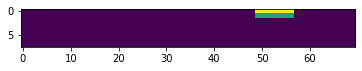

In [41]:
plt.imshow(img[72:,5:75])

In [55]:
len(np.where((img[70:72,5:75])!= 0)[0])

0

In [34]:
np.where(img[72:,5:75]!=0)[1][0]

44

In [36]:
origin_img = env.render(mode='rgb_array')

In [38]:
img = preprocess(origin_img)

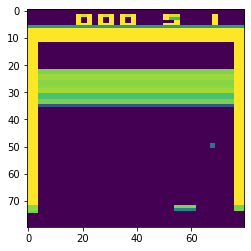

In [40]:
plt.imshow(img)